# Classifier Approach

Testing the idea to build a classifier that directly predicts actions based on observations of a toy example.

$c: X \rightarrow A$ 

$c(x) = a^*$ with $d^* = \argmin_a \int_\theta p(\theta|x) \mathcal{l}(\theta, a) d\theta$ 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt

from loss_calibration.classifier import train, build_classifier, get_raw_stats
from loss_calibration.npe import train_npe
from loss_calibration.loss import StepLoss_weighted, BCELoss_weighted
import loss_calibration.toy_example as toy
from loss_calibration.plot import plot_loss, plot_predictions
from loss_calibration.utils import load_data, posterior_ratio_given_samples, raw_stats_given_predictions

## Toy Example

In [3]:
prior = toy.get_prior()
simulator = toy.get_simulator()

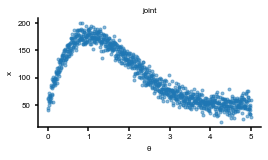

In [4]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(4,2))
    thetas = torch.linspace(0, 5, 1000)
    ax.scatter(thetas, simulator(thetas), alpha=0.5); 
    ax.set_xlabel(r'$\theta$'); ax.set_ylabel('x'); ax.set_title('joint')
    #plt.savefig('results/1d_classifier/1D_clf_joint.pdf')
    plt.show()

Ground Truth Posterior

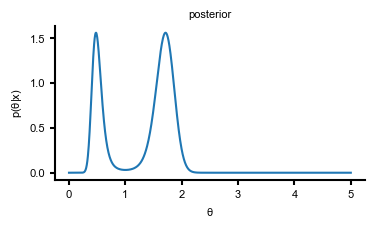

In [5]:
lower = 0
upper = 5
resolution=1000
x = 150
posterior_evals = toy.gt_posterior(torch.tensor([x]), lower, upper, resolution)

with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize = (4,2))
    thetas = torch.linspace(lower, upper, resolution)
    ax.plot(thetas, posterior_evals)
    ax.set_xlabel(r'$\theta$'); ax.set_ylabel(r'$p(\theta|x)$'); ax.set_title('posterior')
    plt.show()


## Decision Making
Define costs and threshold for decision-making

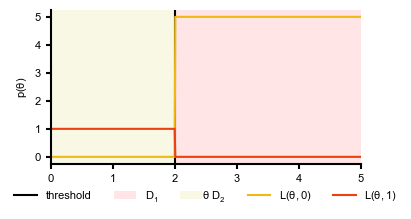

In [6]:
threshold = 2.0
costs = [5.,1.]  
loss = StepLoss_weighted(costs, threshold=threshold)
plot_loss(loss, lower, upper, threshold, resolution=500)

## Data

In [7]:
theta_train, x_train, theta_val, x_val, theta_test, x_test = load_data("toy_example")
theta_train = theta_train[:100_000]
x_train = x_train[:100_000]
theta_val = theta_val[:10_000]
x_val = x_val[:10_000]
theta_test = theta_test[:10_000]
x_test = x_test[:10_000]
print(f"N_train = {theta_train.shape[0]}, N_val = {theta_val.shape[0]}, N_test = {theta_test.shape[0]}")

Load data from './data/toy_example'.
N_train = 100000, N_val = 10000, N_test = 10000


## Classifier

In [8]:
clf = build_classifier("fc", x_train, [20, 20, 20], 1)
clf

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=1, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
  )
  (final_layer): Linear(in_features=20, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [9]:
clf, train_loss, val_loss = train(clf, x_train, theta_train, x_val, theta_val, costs, threshold, learning_rate=0.001, model_dir="./results/test/", max_num_epochs=50, stop_after_epochs=5)

Maximum number of epochs `max_num_epochs=50` reached,but network has not yet fully converged. Consider increasing it.


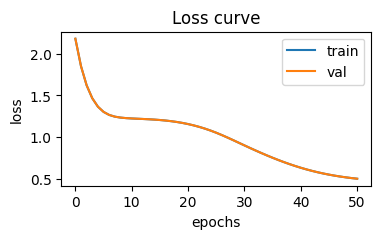

In [10]:
fig, ax = plt.subplots(1,1, figsize = (4,2))
ax.plot(train_loss, label="train")
ax.plot(train_loss, label = "val")
ax.set_title("Loss curve"); ax.set_xlabel("epochs"); ax.set_ylabel("loss")
ax.legend()
plt.show()

### Evaluate trained model on test data

In [11]:
d_test = (theta_test > threshold).float()
ratio_predicted = clf(x_test)
d_predicted = (ratio_predicted > 0.5).float()

In [12]:
accuracy = sum(d_test == d_predicted)/x_test.shape[0]
accuracy.item()

0.8953999876976013

Predictions

In [13]:
tp, fn, fp, tn = raw_stats_given_predictions(d_predicted, theta_test, threshold)
print(f"TP: {sum(tp).item()}\t FN: {sum(fn).item()}\nFP: {sum(fp).item()}\t TN: {sum(tn).item()}\nTotal: {d_predicted.shape[0]}")

TP: 5927	 FN: 52
FP: 994	 TN: 3027
Total: 10000


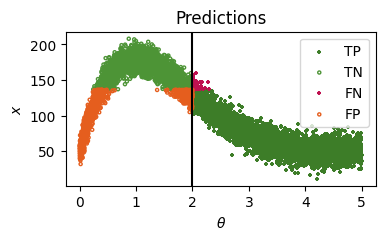

In [14]:
fig, ax = plot_predictions(d_predicted, theta_test, x_test, threshold, marker_size=5)
plt.show()

Incurred Costs

In [15]:
max_costs = max(costs) * theta_test.shape[0]
max_costs

50000.0

In [16]:
incurred_costs = sum(fn) * costs[1] + sum(fp) * costs[0]
incurred_costs.item()

5022.0

Decision Boundary

In [17]:
# find decision boundary
x_linspace = torch.linspace(x_train.min().item(),x_train.max().item(), 1000).unsqueeze(dim=1)
ratios_predicted_linspace = clf(x_linspace)
decision_boundary_idx = (torch.abs(ratios_predicted_linspace - 0.5)).argmin()

/Users/mgorecki/.virtualenvs/bm_venv_sbi18/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


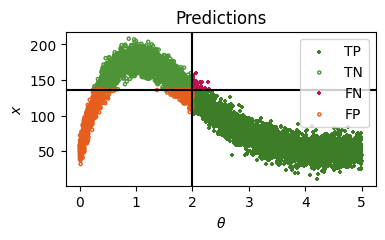

In [18]:
fig, ax = plot_predictions(d_predicted, theta_test, x_test, threshold)
ax.axhline(x_linspace[decision_boundary_idx], c = 'k', label = 'decision boundary')
plt.show()

## NPE

In [19]:
npe_posterior = train_npe("toy_example", theta_train, x_train, max_num_epochs = 50)

 Training neural network. Epochs trained: 51
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 51
        Best validation performance: -0.3189
        -------------------------
        


In [20]:
num_samples = 1000
npe_posterior.sample((num_samples,), x = x)

ratios_npe = []
for x in x_test:
    samples_npe = npe_posterior.sample((num_samples,), x = x, show_progress_bars = False)
    ratio_npe = posterior_ratio_given_samples(samples_npe, threshold, costs)
    ratios_npe.append(ratio_npe)
ratios_npe = torch.as_tensor(ratios_npe)

d_npe = (ratios_npe>0.5).float().unsqueeze(1)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
accuracy_npe = sum(d_test == d_npe)/x_test.shape[0]
accuracy_npe.item()

0.8894000053405762

In [22]:
tp_npe, fn_npe, fp_npe, tn_npe = raw_stats_given_predictions(d_npe, theta_test, threshold)
print(f"TP: {sum(tp).item()}\t FN: {sum(fn).item()}\nFP: {sum(fp).item()}\t TN: {sum(tn).item()}\nTotal: {d_npe.shape[0]}")

TP: 5927	 FN: 52
FP: 994	 TN: 3027
Total: 10000


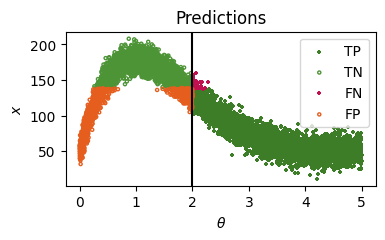

In [23]:
fig, ax = plot_predictions(d_npe, theta_test, x_test, threshold, marker_size=5)
plt.show()

In [24]:
incurred_costs = sum(fn_npe) * costs[1] + sum(fp_npe) * costs[0]
incurred_costs.item()

5350.0